In [8]:
import numpy as np
import numpy.random
import numpy.matlib
import matplotlib.pyplot as plt
from matplotlib import cm

"""
A "from-scratch" neural network implementation for educational purposes.
This version is a simple binary classififer. It allows the user to incrementally
train the network, displaying the resulting decision boundary and full density.
The training data is hard-coded, but there is also a loop to allow more
custom training data. We initialize the weights to be drawn from a standard
Gaussian distribution.

A crude diagram of a NN with two hidden layers and 2-dimensional inputs.
The final layer is returned as a weighted sum, passed through a final
sigmoid function. This scalar will determine which class to assign to the
input point.

x1--O---O
  \ / \ / \ 
   x   x   O --
  / \ / \ /
x2--O---O

@author: Joseph Anderson <jtanderson@salisbury.edu>
@date:   28 May 2019

Exercise 1: vectorize more of the operations, combine the input, output, and
hidden layers into single matrices. 
Exercise 2: Adapt the model to learn more than two classes
Exercise 3: Use "convolutional" or "recurrent" neuron architectures
Exercise 4: Turn into a "generative" model, to generate typical examples
from either of the two classes
Exercise 5: Parallelize!


For motivation/explanation, see, for example:
https://google-developers.appspot.com/machine-learning/crash-course/backprop-scroll/
"""

# The dimensionality of the input data
dim = 2 

# The number of hidden layers
num_layers = 2

# The size of each hidden layer
layer_size = 2

# The step size used in gradient descent
rate = 0.1

bias = False

# add a dimension for bias
if bias:
    dim += 1

# X holds N-by-d samples
#   - N is number of samples
#   - d is dimension
X = np.empty((0,dim), float)

# Y holds N labels of -1 or 1
Y = np.array([])

# input weights. Row i is the array of weights applied to x_i
w_in = np.random.standard_normal((dim,layer_size))

# "Tensor" (3-dim array) of hidden-layer output weights. 
# w_hidden[lay][i][j] is the weight between lay node i and lay+1 node j
w_hidden = np.random.standard_normal((num_layers-1, layer_size, layer_size))

# output weights, comes from last layer
w_out = np.random.standard_normal((1,layer_size))

# Use the standard sigmoid function. Another option is arctan, etc.
def sigmoid(arr):
    return 1/(1+np.exp(-1*arr))

# The derivative of the sigmoid function.
# Check this by hand to see how convenient it is :)
def sigmoid_deriv(arr):
    return sigmoid(arr) * (1 - sigmoid(arr))

# The squared error between to vectors/scalars
def msqerr(pred, ans):
    return np.sum((pred-ans)**2)/2

def reset():
    w_in = np.random.standard_normal((dim,layer_size))
    w_hidden = np.random.standard_normal((num_layers-1, layer_size, layer_size))
    w_out = np.random.standard_normal((1,layer_size))
    return (w_in, w_hidden, w_out)

In [9]:
"""
forward_step takes the weights of the network and an input point,
returning the scalar output of the network, along with a matrix
which is a record of the output of each intermediate node during
the computation. This is needed for training and verification.

Arguments:
inw is the dim-by-h matrix of input weights to the first layer
outw is the h-by-1 array of weights from the last hidden layer to the output node
hiddenw is the num_layers-by-layer_size-by-layer_size matrix of weights between each layer
    hidden[i] has the weights from i to i+1
    hidden[i][j] is the array of weights into node j of layer i+1
data is 1-by-dim row vector

Returns:
scalar value coming out of the output node
outs is layers-by-layer_size to store the output of each node
"""
def forward_step(inw, outw, hiddenw, data):
    outs = np.array([ sigmoid(data @ inw) ]) # 1-by-dim times dim-by-h
    for i in range(1,num_layers):
        # i-1 here because w[i] is output weights
        # get the output of the last layer (sig of x) and weight it into this layer
        ins = outs[-1] @ hiddenw[i-1]  # 1-by-h times h-by-h
        outs = np.append(outs, [sigmoid(ins)], axis=0)

    # last row of outs now holds the weighted output of the last hidden layer
    ret = sigmoid(outs[-1] @ outw.T)
    return ret[0], outs

"""
backprop analyzes how wrong the network was at predicting a given label,
then uses the magnitude of the error to perform gradient descent on the
edge weights throughout the network. Check this with the chain rule
of the error function! It tracks the change in error with respect to weights,
inputs, and outputs of every node in the network

inw: dim-by-layer_size
    weights of the input nodes
outw: 1-by-layer_size
    weights to the output node
hiddenw: num_layers-1 x layer_size x layer_size
    hiddenw[lay][i][j] is the weight between lay node i and lay+1 node j
    a column is all input weights to that node
outputs: num_layers x layer_size
    record of every node's output from the forward pass
pred: scalar predicted output
data: the input data point
label: scalar true output
"""
def backprop(inw, outw, hiddenw, outputs, pred, data, label):
    dEyo = pred - label # scalar
    dExo = dEyo * sigmoid_deriv(np.dot(outputs[-1], outw[0])) # scalar
    dEwo =  dExo * outputs[-1] #np.zeros((1, layer_size)) # out
    
    # hidden layer derivatives setup
    dEwh = np.zeros((num_layers-1, layer_size, layer_size))
    dExh = np.zeros((num_layers, layer_size))
    dEyh = np.zeros((num_layers, layer_size))
    
    # need to do output layer first, not a matrix product
    dEyh[-1] = outw * dExo # 1-by-h times scalar
    dExh[-1] = dEyh[-1] * sigmoid_deriv(dExo)

    for i in range(num_layers-2,-1,-1):
        # i-1 to get the inputs to layer i
        x = outputs[i-1] @ hiddenw[i-1] # 1-by-h times h-by-h
        dExh[i] = dEyh[i] * sigmoid_deriv(x) # 1-by-h
        dEwh[i] = outputs[i-1] * dExh[i]
        if i > 0:
            # prep the next layer
            dEyh[i-1] = hiddenw[i] @ dExh[i].T # h-by-h times h-by-1

    #dEwi = outputs[0] * dEyh[0] # take care of the input layer, again
                                # not a matrix product
    data = numpy.array([data])
    dEwi = np.matlib.repmat(data.T, 1, layer_size) * np.matlib.repmat(dExh[0], dim, 1)  # dim-by-h broadcast dim-by-h


    # adjust the hiden layer weights accoriding to the error.
    # Check to see that this follows gradient descent!
    hiddenw = hiddenw - rate * dEwh
    inw = inw - rate * dEwi
    outw[0] = outw[0] - rate * dEwo

    # return the new weights
    return inw, outw, hiddenw

In [10]:
def train_rounds(train_x, train_y, num_rounds, w_in, w_out, w_hidden):
    # Set up the plotting
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.ion()
    fig.show()
    fig.canvas.draw()
    plt.axis([-4,4,-4,4])
    ax.axis([-4,4,-4,4])
    
    # iterate as long as we're told
    # For each epoch, it would be helpful to print the total "loss" -- the error
    # across the whole training set.
    # Often, one might choose a loss threshold (say, < 0.0001) and simply train until
    # the loss is smaller
    loss = 0
    for i in range(1,num_rounds+1):
        # iterate each data point
        loss = 0
        for j in range(0,train_x.shape[0]):
            dat = train_x[j]
            if bias:
                dat = np.append(train_x[j], [1])

            # get the prediction for the point, using the current weights (model)
            pred, vals = forward_step(w_in, w_out, w_hidden, dat)
            # adjust the weights (model) to account for whether we're incorrect
            w_in, w_out, w_hidden = backprop(w_in, w_out, w_hidden, vals, pred, dat, train_y[j])
            loss += abs(pred - train_y[j])**2
    print("Current loss: " + str(loss))

    ax.clear()
    p_x, p_y = (train_x[np.where(train_y==1)]).T
    ax.plot(p_x, p_y, 'ob')
    p_x, p_y = (train_x[np.where(train_y==-1)]).T
    ax.plot(p_x, p_y, 'or')
    ax.axis([-4,4,-4,4])

    """
    Plot the decision area contours
    """

    # Set up some arrays to compute the contours, store in an image
    im_x = np.arange(-4,4,0.1)
    im_y = np.arange(-4,4,0.1)
    im_X, im_Y = np.meshgrid(im_x, im_y)

    # values
    im_Z = [] # np.zeros(im_X.shape)

    # TODO: use list comp, zipping, and mapping for this, for-loop is slow
    for j in range(len(im_X)): # walk over rows
        for i in range(len(im_X[0])): # walk over columns
            # Get the value for 
            # swap i and j to compensate for grid layout
            dat = np.array([im_X[j][i], im_Y[j][i]]) # without bias
            if(bias):
                dat = np.append(dat, [1]) # add bias input
            res, _ = forward_step(w_in, w_out, w_hidden, dat) # with bias
            im_Z.append(res)

    im_Z = numpy.array(im_Z).reshape(im_X.shape)

    # see the matplotlib contourf documentation
    cset1 = plt.contourf(im_X, im_Y, im_Z, cmap='RdBu', alpha=0.5)
    fig.canvas.draw()
    return (w_in, w_out, w_hidden)

In [11]:
"""
Hard-code more points, or adjust as needed.
Check to make sure the structure matches the assumptions above
"""

# Input data, linearly separable classes
# Even for this setup, the network can have a tough time getting a good model!
# Sometimes you can even hit a "local" minimum where more training doesn't help,
# we need to perturb things a bit or get more data.
X = np.array(
    [
        [ 0.2, 2.2 ],
        [ -1.9, -0.3],
        [ 1, -1],
        #[ -1, 1]
    ]
)

# The labels
Y = np.array([1, 1, -1])

epochs = 1000

# To run and get updated weights:
# w_in, w_out, w_hidden = train_rounds(X, Y, epochs, w_in, w_out, w_hidden)

In [12]:
w_in, w_hidden, w_out = reset()

/tmp/ipykernel_36348/3322038333.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Current loss: 0


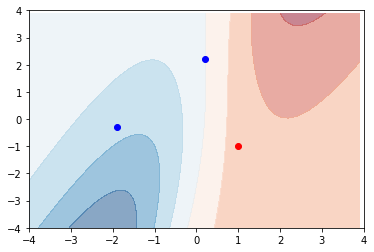

In [13]:
w_in, w_out, w_hidden = train_rounds(X, Y, 0, w_in, w_out, w_hidden)

/tmp/ipykernel_36348/3322038333.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Current loss: 2.676209098448572


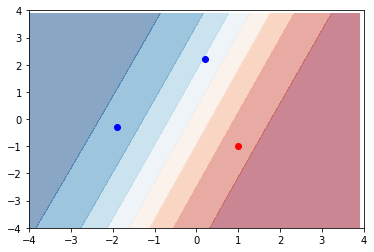

In [15]:
w_in, w_out, w_hidden = train_rounds(X, Y, 10, w_in, w_out, w_hidden)

/tmp/ipykernel_36348/3322038333.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Current loss: 2.659262712653409


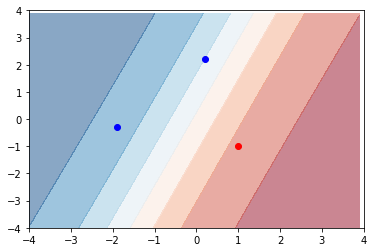

In [16]:
w_in, w_out, w_hidden = train_rounds(X, Y, 10, w_in, w_out, w_hidden)